# Eigenfaces Algorithm

### Eigenfaces are constructed by projecting a group of faces onto a small dimensional space (in this case 150) by means of Principal Components (PCA) and Support Vector Machines (SVM).

### Faces are identified by their location in this "Face Space"

### This code uses the Caltech Faces dataset.  The details of the data loading are done in the utility load_caltech_faces.  The following code is largely a port of PyImageSearch to Jupyter.  Because PyImageSearch code uses CV2 extensively and because cv2.imshow() does not play nice with Jupyter, the image display functionality is ported to matplotlib.

#### This notebook contains seven steps
1. First the data is loaded and separated into training and testing datasets
2. A random set of training images are shown
3. The PCA is initialized and fit (trained)
4. The results of PCA decomposition are shown, the mean (average) face and the first 16 Principal Components
5. The SVM is instantiated and trained
6. The SVM model based on the PCA derived Eigenfaces is evaluated 
7. A sample of the predicted faces are presented

##### Import required libraries

In [2]:
%matplotlib inline
from loader import load_caltech_faces
from resultsmontage import ResultsMontage
from plot import plotArray
from plot import plotArray1Row
import sklearn
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from skimage import exposure
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow

import matplotlib.pyplot as plt
import numpy as np
import random

##### Get the data.  This implementation is on Windows, so the path requires escaped backspaces

##### load_caltech_faces performs the following functions:
* Load the image and convert it to grayscale
* Grab the bounding box associated with the current image, 
* Extract the face ROI, and resize it to a canonical size
* If the flatten flag is set, flatten to a vector
* Append the canonical sized face to a data matrix
* Convert the data matrix to a NumPy array
* Associate the data labels with the correct faces
* Check to see that the minimum number of faces are present
* Shuffle the data
* Split the data into testing and training
* Return Training, Testing and Labels

In [3]:
ctf = 'C:\\Working\\PyImage\\faces\\caltech_faces'
(training, testing, names) = load_caltech_faces(ctf, min_faces=21, flatten=True,test_size=0.25)

### Examine the training data

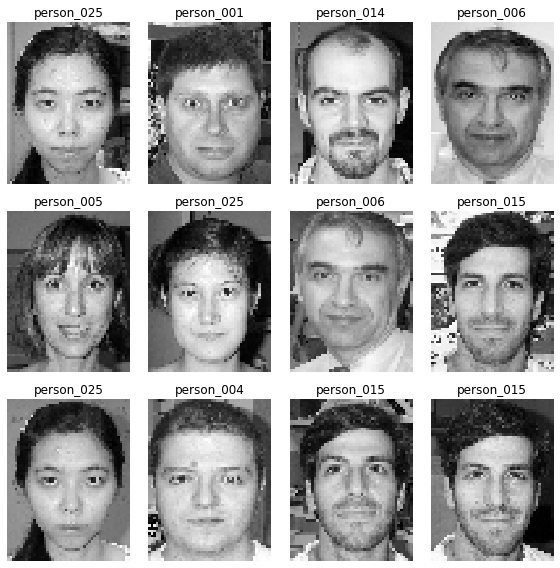

In [4]:
sample_view = []
sample_img = []
sample_tit = []
for i in range(12):
    sample_view.append(random.randint(0,len(training.target)))
for i in range(len(sample_view)):
    sample_img.append(training.data[sample_view[i]].reshape((62, 47)).astype("uint8"))
    sample_tit.append(training.target[sample_view[i]])
plotArray(sample_img, sample_tit, 3,4,(8,8),font=12)

### Compute the Eigenfaces
* Each image is 62x47 pixels or 2914 total pixels
* The images are flattened - turned into 1x2914 vectors
* The images are stacked on top of each other to form a Zx2914 matrix M
* M is normalized by subtracting the column mean from each element of the column
* Principal Component Analysis is performed on M yielding  eigenvectors
* The Eigenvectors are sorted, largest to smallest
* The top N (150) eigenvectors are used to transform the data by projecting (dot product) into the space created by the N eigenvectors
* The eigenvectors are called eigenfaces.




In [5]:
#set some constants
pca_components = 150
sample_size = 12
visualize = True

In [6]:
print("[INFO] creating eigenfaces...")
pca = PCA(svd_solver="randomized", n_components=pca_components, whiten=True)
trainData = pca.fit_transform(training.data)

[INFO] creating eigenfaces...


### Visualize the eigenfaces

* The Mean Face is the element-wise average of all faces in the dataset
* The montage of 16 eigenfaces are the top Principal Components output by the algorithm


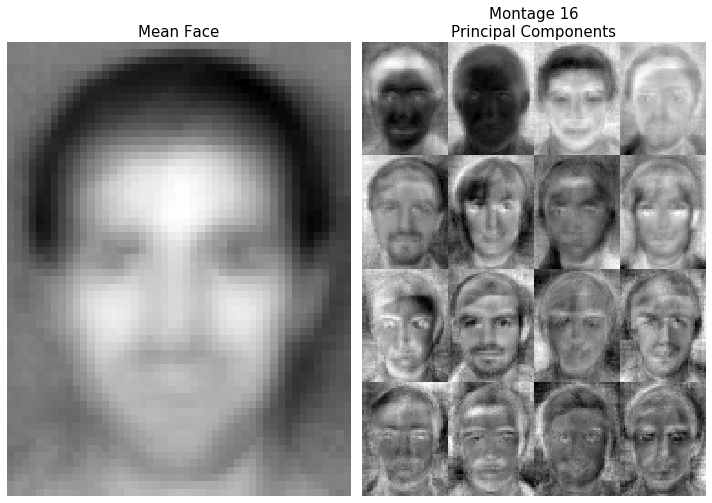

In [7]:
if  visualize:
    
    montage = ResultsMontage((62, 47), 4, 16)
    # loop over the first 16 individual components
    for (i, component) in enumerate(pca.components_[:16]):
        # reshape the component to a 2D matrix, then convert the data type to an unsigned
        # 8-bit integer so it can be displayed with OpenCV
        component = component.reshape((62, 47))
        component = exposure.rescale_intensity(component, out_range=(0, 255)).astype("uint8")
        component = np.dstack([component] * 3)
        montage.addResult(component)
        
    # show the mean and principal component visualizations
    # show the mean image
    mean = pca.mean_.reshape((62, 47))
    mean = exposure.rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
    imags =[mean, montage.montage]
    titls = ["Mean Face", "Montage 16\nPrincipal Components"]
    plotArray1Row(imags,titls,2,(10,10),font=15)
    

#### Eigenfaces can be used as a classifier (face identifier) by computing the euclidean distance between faces.  However, increased accuracy is possible by using additional ML algorithms .  In this case, a Support Vector Machine (SVM) is instantiated.

#### Instantiate and train the SVM Classifier

In [8]:
print("[INFO] training classifier...")
model = SVC(kernel="rbf", C=10.0, gamma=0.001, random_state=84)
model.fit(trainData, training.target)

[INFO] training classifier...


SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=84, shrinking=True, tol=0.001,
    verbose=False)

#### Evaluate the Classifier

In [9]:
print("[INFO] evaluating model...")
predictions = model.predict(pca.transform(testing.data))
print(classification_report(testing.target, predictions))

[INFO] evaluating model...
              precision    recall  f1-score   support

  person_001       0.80      1.00      0.89         4
  person_004       1.00      1.00      1.00         6
  person_005       1.00      1.00      1.00         6
  person_006       1.00      1.00      1.00         3
  person_009       1.00      1.00      1.00         6
  person_014       1.00      1.00      1.00         6
  person_015       1.00      1.00      1.00         4
  person_016       1.00      1.00      1.00         7
  person_020       1.00      0.80      0.89         5
  person_023       1.00      1.00      1.00         5
  person_025       1.00      1.00      1.00         5
  person_026       1.00      1.00      1.00         6

    accuracy                           0.98        63
   macro avg       0.98      0.98      0.98        63
weighted avg       0.99      0.98      0.98        63



##### Examine some of the predictions

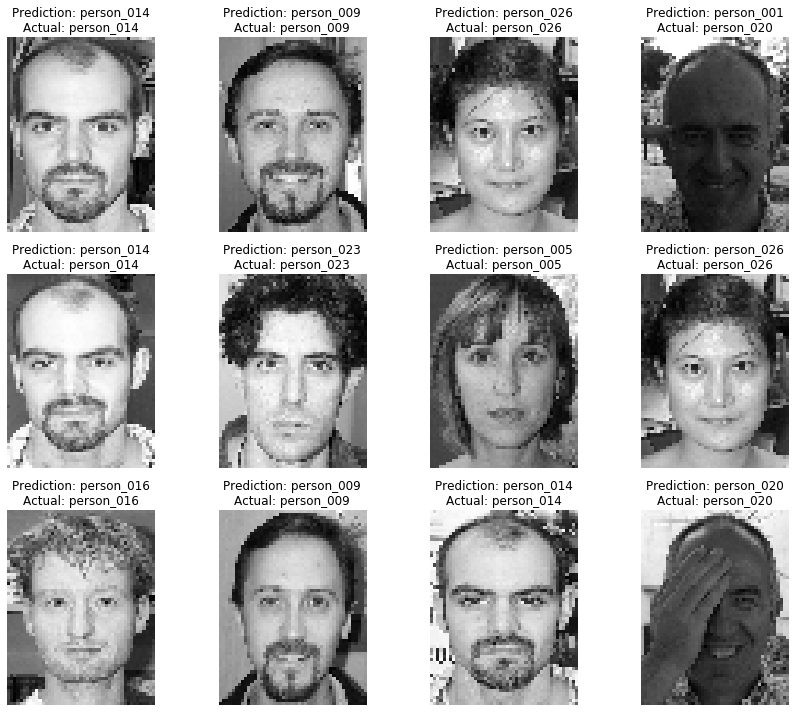

In [11]:
images = []
titles = []

for i in np.random.randint(0, high=len(testing.data), size=sample_size):   #i is the number of the face to get
    # grab the face and classify it
    face = testing.data[i].reshape((62, 47)).astype("uint8")
    pred_name = model.predict(pca.transform(testing.data[i].reshape(1, -1)))
    face_name = testing.target[i]
    
    images.append(face)
    titles.append("Prediction: "+ pred_name[0] +"\nActual: "+ face_name)
plotArray(images, titles, 3,4,(12,10),font=12)  